#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew
from tqdm import tqdm
import pymannkendall as mk
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import boxcox
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

#### Read dataset

In [2]:
df_general = pd.read_excel('../input/Copy of 8423900_1.xlsx', sheet_name='Dataset 1 - General', header=[0, 1])
df_general.columns = [' '.join(col) for col in df_general.columns]
df_general.columns = ['firm'] + list(df_general.columns[1:])
df_underwriting = pd.read_excel('../input/Copy of 8423900_1.xlsx', sheet_name='Dataset 2 - Underwriting', header=[0, 1])
df_underwriting.columns = [' '.join(col) for col in df_underwriting.columns]
df_underwriting.columns = ['firm'] + list(df_underwriting.columns[1:])

In [3]:
df = df_general.merge(df_underwriting, how='outer')
df

,firm,NWP (£m) 2016YE,NWP (£m) 2017YE,NWP (£m) 2018YE,NWP (£m) 2019YE,NWP (£m) 2020YE,SCR (£m) 2016YE,SCR (£m) 2017YE,SCR (£m) 2018YE,SCR (£m) 2019YE,...,Gross expense ratio 2016YE,Gross expense ratio 2017YE,Gross expense ratio 2018YE,Gross expense ratio 2019YE,Gross expense ratio 2020YE,Gross combined ratio 2016YE,Gross combined ratio 2017YE,Gross combined ratio 2018YE,Gross combined ratio 2019YE,Gross combined ratio 2020YE
0,Firm 1,-17754.100486,0.000000,0.000000,0.000000,0.000000,2021.321862,6.940043e-09,0.000000,0.000000,...,0.000000,77.251254,0.000000,0.000000,0.000000,0.000000,0.675051,0.000000,0.000000,0.000000
1,Firm 10,404.116022,3882.087306,6640.433866,5196.618355,221.986516,3839.041694,5.102459e+03,2578.827206,323.481575,...,0.126954,0.025789,0.605825,0.455562,0.374612,1.520116,0.350161,1.291962,0.357412,0.306303
2,Firm 100,22.372518,16.450420,5.194659,49.257908,55.765640,34.142618,9.900711e+00,43.045767,12.302450,...,0.355723,0.374440,0.043240,0.039222,0.299416,0.858371,0.463985,0.143006,1.378278,1.013963
3,Firm 101,7932.403100,3304.202645,2397.454118,4804.131318,0.000000,438.929248,7.521082e+03,7134.264916,3369.613372,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Firm 102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.652722e-01,0.000000,0.000000,...,0.267615,0.123200,0.774337,0.520459,1.085284,1.506229,0.890565,1.351558,1.114826,0.852866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,Firm 95,0.000000,0.022100,0.003770,0.000000,0.000000,1.083507,9.200830e-01,0.673003,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
452,Firm 96,-0.019008,0.003815,0.000000,0.000000,0.000000,10.369717,3.359330e+01,0.000000,0.000000,...,0.616412,0.440711,0.561195,0.000000,0.000000,1.616303,0.930160,0.631420,0.000000,0.000000
453,Firm 97,8.738470,6.659647,8.899938,3.421385,3.255363,26.025478,2.949441e+01,26.826963,17.100169,...,0.255339,0.044398,0.282682,0.221536,0.190320,1.476490,1.018612,0.965426,1.746108,0.981762
454,Firm 98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.950606,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Task I

Using the data provided, please analyse this data using a programming language of your choosing and produce a short report, including tables and charts, to highlight which firms should receive the most attention, according to the metrics above.

In [4]:
nwp_columns = [col for col in df_general.columns if col.startswith('NWP (£m)')]
scr_columns = [col for col in df_general.columns if col.startswith('SCR (£m)')]
eof_scr_columns = [col for col in df_general.columns if col.startswith('EoF for SCR (£m)')]
scr_ratio_columns = [col for col in df_general.columns if col.startswith('SCR coverage ratio')]
turn_over_columns = [col for col in df_general.columns if col.startswith('GWP (£m)')]
total_assets_columns = [col for col in df_general.columns if col.startswith('Total assets (£m)')]
total_liabilities_columns = [col for col in df_general.columns if col.startswith('Total liabilities (£m)')]
equity_columns = [col for col in df_general.columns if col.startswith('Excess of assets over liabilities (£m) [= equity]')]

gci_columns = [col for col in df_underwriting.columns if col.startswith('Gross claims incurred (£m)')]
gbel_columns = [col for col in df_underwriting.columns if col.startswith('Gross BEL (inc. TPs as whole, pre-TMTP) (£m)')]
nbel_columns = [col for col in df_underwriting.columns if col.startswith('Net BEL (inc. TPs as a whole, pre-TMTP) (£m)')]
pnc_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Pure net claims ratio')]
ne_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Net expense ratio')]
nc_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Net combined ratio')]
pgc_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Pure gross claims ratio')]
ge_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Gross expense ratio')]
gc_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Gross combined ratio')]

feature_columns = [nwp_columns]+[scr_columns]+[eof_scr_columns]+[scr_ratio_columns]+[turn_over_columns]+[total_assets_columns]+[total_liabilities_columns]+[equity_columns]+[gci_columns]+[gbel_columns]+[nbel_columns]+[pnc_ratio_columns]+[ne_ratio_columns]+[nc_ratio_columns]+[pgc_ratio_columns]+[ge_ratio_columns]+[gc_ratio_columns]

In [5]:
df_general

,firm,NWP (£m) 2016YE,NWP (£m) 2017YE,NWP (£m) 2018YE,NWP (£m) 2019YE,NWP (£m) 2020YE,SCR (£m) 2016YE,SCR (£m) 2017YE,SCR (£m) 2018YE,SCR (£m) 2019YE,...,Total liabilities (£m) 2016YE,Total liabilities (£m) 2017YE,Total liabilities (£m) 2018YE,Total liabilities (£m) 2019YE,Total liabilities (£m) 2020YE,Excess of assets over liabilities (£m) [= equity] 2016YE,Excess of assets over liabilities (£m) [= equity] 2017YE,Excess of assets over liabilities (£m) [= equity] 2018YE,Excess of assets over liabilities (£m) [= equity] 2019YE,Excess of assets over liabilities (£m) [= equity] 2020YE
0,Firm 1,-17754.100486,0.000000,0.000000,0.000000,0.000000,2021.321862,6.940043e-09,0.000000,0.000000,...,40171.683156,0.000000,0.000000,0.000000,0.000000,1243.924991,4.398725,0.000000,0.000000,0.000000
1,Firm 2,9.244369,0.098771,40.812426,35.643071,13.626145,16.459756,1.500907e+01,14.227214,15.037066,...,7.970519,12.796789,11.332857,6.730190,16.173862,8.755261,48.425189,0.070823,43.368380,12.456319
2,Firm 3,0.000000,0.806130,36.620199,86.630018,54.744180,486.887796,4.957863e+02,626.612217,81.242579,...,68.000844,1592.310597,1005.328927,593.689101,374.712155,210.918808,100.776891,87.586067,922.487659,412.466207
3,Firm 4,19677.453353,41072.816156,20885.506445,14719.672914,49204.465136,15975.652771,1.536789e+04,10797.123319,22788.359468,...,48416.743356,30870.226541,68145.069079,92600.140108,92273.053968,24862.167211,7191.961836,12910.346383,12586.973993,24127.839035
4,Firm 5,128.812208,10.407371,79.579663,79.423623,61.727295,32.742279,4.395404e+01,31.622572,30.119285,...,267.458967,22.979292,69.343245,16.837470,106.179543,262.683530,7.592281,96.945192,104.609768,103.180972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Firm 321,0.000000,0.000000,-0.167178,-6.813367,31.258806,0.000000,3.652140e-01,70.399156,68.655722,...,0.000000,0.005647,1776.379248,1843.139217,10455.584133,0.000000,0.021877,23.475958,125.140116,60.013312
321,Firm 322,3315.466643,4136.476625,2192.750865,2252.917257,2780.628432,578.238997,1.926540e+03,1366.552217,849.073657,...,5978.084709,5250.432938,4906.432272,6204.396397,5566.091662,3860.015668,2114.645213,3198.394329,1029.870659,3640.241631
322,Firm 323,0.000000,0.000000,0.000000,0.000000,0.000000,6.459131,2.803774e+01,5.689804,1.674462,...,40.153398,33.497286,30.445115,17.823604,13.019950,73.650380,88.869984,92.834958,91.194544,2.725257
323,Firm 324,29.811172,21.003008,13.551740,6.145755,49.793157,45.967315,5.732320e+01,36.910810,1.012305,...,253.309101,353.395687,273.736970,354.965671,298.298975,61.397880,63.084690,73.016922,11.684645,21.921881


##### Method 1:

Firm size (i.e. the biggest firms need more attention)

Gross Written Premium (GWP) – total revenue written by an insurer. Equivalent of turnover

for a non-insurance firm.

In [6]:
df_general['Total assets'] = df_general[total_assets_columns].sum(axis=1)
df_general['Total liabilities'] = df_general[total_liabilities_columns].sum(axis=1)
df_general['GWP'] = df_general[turn_over_columns].sum(axis=1)
df_general['GWP Rank'] = df_general['GWP'].rank(method='dense', ascending=False)
df_general['Net Worth'] = df_general['Total assets'] - df_general['Total liabilities']
df_general['Net Worth Rank'] = df_general['Net Worth'].rank(method='dense', ascending=False)
df_general = round(df_general, 2)
df_general

,firm,NWP (£m) 2016YE,NWP (£m) 2017YE,NWP (£m) 2018YE,NWP (£m) 2019YE,NWP (£m) 2020YE,SCR (£m) 2016YE,SCR (£m) 2017YE,SCR (£m) 2018YE,SCR (£m) 2019YE,...,Excess of assets over liabilities (£m) [= equity] 2017YE,Excess of assets over liabilities (£m) [= equity] 2018YE,Excess of assets over liabilities (£m) [= equity] 2019YE,Excess of assets over liabilities (£m) [= equity] 2020YE,Total assets,Total liabilities,GWP,GWP Rank,Net Worth,Net Worth Rank
0,Firm 1,-17754.10,0.00,0.00,0.00,0.00,2021.32,0.00,0.00,0.00,...,4.40,0.00,0.00,0.00,63686.44,40171.68,46.77,191.0,23514.75,14.0
1,Firm 2,9.24,0.10,40.81,35.64,13.63,16.46,15.01,14.23,15.04,...,48.43,0.07,43.37,12.46,259.91,55.00,80.17,173.0,204.91,140.0
2,Firm 3,0.00,0.81,36.62,86.63,54.74,486.89,495.79,626.61,81.24,...,100.78,87.59,922.49,412.47,5104.43,3634.04,392.89,127.0,1470.39,69.0
3,Firm 4,19677.45,41072.82,20885.51,14719.67,49204.47,15975.65,15367.89,10797.12,22788.36,...,7191.96,12910.35,12586.97,24127.84,397630.20,332305.23,214185.52,2.0,65324.97,8.0
4,Firm 5,128.81,10.41,79.58,79.42,61.73,32.74,43.95,31.62,30.12,...,7.59,96.95,104.61,103.18,931.97,482.80,241.73,141.0,449.17,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,Firm 321,0.00,0.00,-0.17,-6.81,31.26,0.00,0.37,70.40,68.66,...,0.02,23.48,125.14,60.01,13261.42,14075.11,79.05,175.0,-813.69,281.0
321,Firm 322,3315.47,4136.48,2192.75,2252.92,2780.63,578.24,1926.54,1366.55,849.07,...,2114.65,3198.39,1029.87,3640.24,29870.03,27905.44,8206.39,36.0,1964.59,60.0
322,Firm 323,0.00,0.00,0.00,0.00,0.00,6.46,28.04,5.69,1.67,...,88.87,92.83,91.19,2.73,345.14,134.94,0.00,259.0,210.21,139.0
323,Firm 324,29.81,21.00,13.55,6.15,49.79,45.97,57.32,36.91,1.01,...,63.08,73.02,11.68,21.92,2034.69,1533.71,506.92,118.0,500.99,98.0


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_firms(df, top_n=20):
    """
    Plot top firms by net worth using Seaborn.

    Parameters:
        df (DataFrame): DataFrame containing data of top firms by net worth.
        top_n (int): Number of top firms to plot.

    Returns:
        top_net_worth_firms (DataFrame): DataFrame containing top firms by net worth.
    """
    # Sort the DataFrame by net worth rank and GWP rank
    df = df.sort_values(by=['Net Worth Rank', 'GWP Rank'])
    
    # Select the top n firms by net worth
    top_net_worth_firms = df.head(top_n)
    
    # Create scatter plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=top_net_worth_firms, x='Net Worth', y='GWP', hue='firm', s=800)
    
    # Set plot title and axis labels
    plt.title('Top Firms by Net Worth')
    plt.xlabel('Net Worth')
    plt.ylabel('Turn Over')
    
    # Show the plot
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.grid(True)
    plt.show()
    
    return top_net_worth_firms

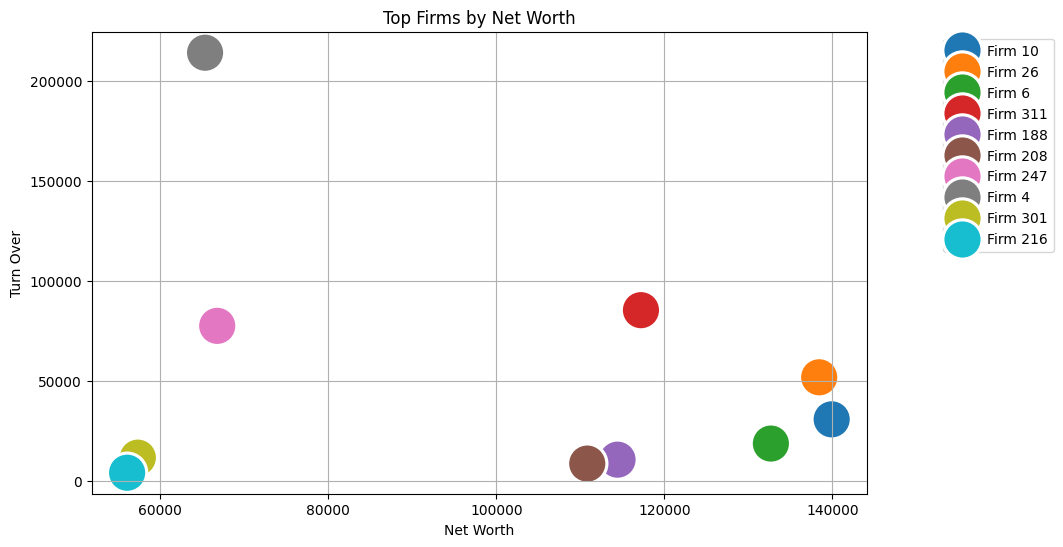

In [8]:
top_net_worth_firms = plot_top_firms(df_general, top_n=10)

##### Method 2

Changing business profile (are firms’ data changing substantially year-on-year?)

Outliers from the norm (when looking at a single reporting period, does a firm deviate significantly from the average?)

In [9]:
def plot_turnover(df, col, y_range):
    """
    Plot turnover for all firms over five years using Plotly.

    Parameters:
        df (DataFrame): Input DataFrame containing turnover data for multiple firms over five years.

    Returns:
        None (plots the graph using Plotly).
    """
    # Calculate mean YoY growth for each year
    mean_growth = df.groupby('Year')['YoY_Growth'].mean()

    # Create traces for each firm
    traces = []
    for firm in df['firm'].unique():
        firm_data = df[df['firm'] == firm]
        
        trace = go.Scatter(
            x=firm_data['Year'],
            y=firm_data[col],
            mode='lines+markers',
            name=firm
        )
        traces.append(trace)
    
    # Create trace for mean YoY growth
    trace_mean_growth = go.Scatter(
        x=mean_growth.index,
        y=mean_growth.values,
        mode='markers',
        name='Mean YoY Growth',
        marker=dict(color='black', size=12, symbol='circle'),
        text=[f'Mean YoY Growth: {growth:.2f}%' for growth in mean_growth.values]
    )
    traces.append(trace_mean_growth)
    
    layout = go.Layout(
        title='Turnover Over Five Years with Cap growth of 1000% and -500%',
        xaxis=dict(title='Year'),
        yaxis=dict(title='YoY_Growth', range=y_range)
    )

    # Create figure and plot
    fig = go.Figure(data=traces, layout=layout)
    fig.show()


def turnover_growth(df):
    melted_df = pd.melt(df[['firm']+turn_over_columns], id_vars=['firm'], value_vars=turn_over_columns, var_name='Year', value_name='turnover')
    melted_df['Year'] = melted_df['Year'].str.extract(r'(\d{4})YE')
    melted_df = melted_df.sort_values(by=['firm', 'Year'])
    melted_df['YoY_Growth'] = melted_df.groupby('firm')['turnover'].pct_change() * 100
    melted_df['YoY_Growth'] = melted_df['YoY_Growth'].replace([np.inf, -np.inf], 0).fillna(0)
    melted_df.reset_index(drop=True, inplace=True)
    return melted_df


In [10]:
turnover_df = turnover_growth(df_general)
turnover_df['YoY_Growth_Capped'] = [1000 if x > 1000 else (-500 if x < -500 else x) for x in turnover_df['YoY_Growth']]
plot_turnover(turnover_df, col = 'YoY_Growth_Capped', y_range=[-550, 1050])

In [11]:

def plot_yoy_growth_boxplot(df, ylim=None):
    """
    Plot box plot for year-over-year (YoY) growth for each year using Plotly Express.

    Parameters:
        df (DataFrame): Input DataFrame containing turnover data for multiple firms over multiple years.
        ylim (tuple): Optional. Tuple containing the lower and upper limits of the y-axis.

    Returns:
        None (plots the graph using Plotly).
    """

    df = df[df.Year!='2016']
    # Plot box plot for YoY growth for each year
    fig = px.box(df, x='Year', y='YoY_Growth', points='all', title='Year-over-Year Growth Box Plot',
                 labels={'YoY_Growth': 'Year-over-Year Growth (%)'})
    
    if ylim:
        fig.update_yaxes(range=list(ylim))  # Convert tuple to list
        
    fig.update_layout(showlegend=False)

    # Show plot
    fig.show()


In [12]:
plot_yoy_growth_boxplot(turnover_df, ylim=(-150, 200))

In [13]:
def find_outliers_by_year(df, year_column, yoy_growth_column):
    result = []
    
    for year in df[year_column].unique():
        year_data = df[df[year_column] == year]
        q1 = year_data[yoy_growth_column].quantile(0.25)
        q3 = year_data[yoy_growth_column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        upper_outliers = year_data[year_data[yoy_growth_column] > upper_bound]
        lower_outliers = year_data[year_data[yoy_growth_column] < lower_bound]
        
        upper_outliers_list = upper_outliers['firm'].tolist()
        lower_outliers_list = lower_outliers['firm'].tolist()
        
        upper_outliers_count = len(upper_outliers_list)
        lower_outliers_count = len(lower_outliers_list)
        
        result.append({
            'Year': year,
            'Upper_Bound_Firms': ', '.join(upper_outliers_list),
            'Upper_Bound_Counts': upper_outliers_count,
            'Lower_Bound_Firms': ', '.join(lower_outliers_list),
            'Lower_Bound_Counts': lower_outliers_count
        })
    
    return pd.DataFrame(result)

outliers_df = find_outliers_by_year(turnover_df, 'Year', 'YoY_Growth')
outliers_df

,Year,Upper_Bound_Firms,Upper_Bound_Counts,Lower_Bound_Firms,Lower_Bound_Counts
0,2016,,0,,0
1,2017,"Firm 10, Firm 100, Firm 110, Firm 114, Firm 11...",55,"Firm 207, Firm 230, Firm 313, Firm 61",4
2,2018,"Firm 104, Firm 105, Firm 106, Firm 118, Firm 1...",45,"Firm 230, Firm 316, Firm 55",3
3,2019,"Firm 107, Firm 113, Firm 139, Firm 146, Firm 1...",42,Firm 144,1
4,2020,"Firm 100, Firm 104, Firm 118, Firm 123, Firm 1...",45,"Firm 152, Firm 186, Firm 316",3


##### Method 3
Net Written Premium (NWP) – GWP less reinsurance. NWP / GWP will show how much of the firm’s risk is being passed on to reinsurers.

In [14]:
def melt_columns(df, coloum_list, new_column_name, is_yoy = True):
    melted_df = pd.melt(df[['firm']+coloum_list], id_vars=['firm'], value_vars=coloum_list, var_name='Year', value_name=new_column_name)
    melted_df['Year'] = melted_df['Year'].str.extract(r'(\d{4})YE')
    melted_df = melted_df.sort_values(by=['firm', 'Year'])
    if is_yoy:
        melted_df['YoY_Growth'] = melted_df.groupby('firm')[new_column_name].pct_change() * 100
        melted_df['YoY_Growth'] = melted_df['YoY_Growth'].replace([np.inf, -np.inf], 0).fillna(0)
    melted_df.reset_index(drop=True, inplace=True)
    return melted_df

In [15]:
df_nwp = melt_columns(df=df_general, coloum_list=nwp_columns, new_column_name='NWP', is_yoy=False)
df_gwp = melt_columns(df=df_general, coloum_list=turn_over_columns, new_column_name='GWP', is_yoy=False)
df_firm_risk = df_nwp.merge(df_gwp)
df_firm_risk['firm_risk'] = df_firm_risk['NWP']/df_firm_risk['GWP']
df_firm_risk = round(df_firm_risk.fillna(0),2)
df_firm_risk['firm_risk'] = df_firm_risk['firm_risk'].replace([np.inf, -np.inf], 0).fillna(0)
df_firm_risk['is_risk'] = [1 if x<0 else 0 for x in df_firm_risk['firm_risk']]
df_firm_risk_index = df_firm_risk.groupby(['firm', 'is_risk']).size().reset_index(name='is_risk_count')
df_firm_risk_index = df_firm_risk_index[df_firm_risk_index.is_risk==1].sort_values('is_risk_count', ascending=False)

In [16]:
def plot_bar_chart(df):
    # Sort the DataFrame by 'is_risk_count' in descending order
    df_sorted = df.sort_values(by='is_risk_count', ascending=False)

    # Create a bar chart
    fig = go.Figure(data=[go.Bar(
        x=df_sorted['firm'],
        y=df_sorted['is_risk_count'],
        marker_color=['red' if i < 5 else 'blue' for i in range(len(df_sorted))],  # Highlight top 5 bars
        # text=df_sorted['is_risk_count'],  # Add text labels
        textposition='outside',  # Place text labels outside the bars
    )])

     # Update layout
    fig.update_layout(
        title='Number of Years Firms at risk',
        xaxis=dict(title='Firms'),
        yaxis=dict(title='Number of Years'),
        bargap=0.1,  # Gap between bars
        autosize=False,
        width=800,
        height=600
    )

    # Show the plot
    fig.show()

In [17]:
plot_bar_chart(df_firm_risk_index)

#### Method 4
Gross claims incurred – a large cost to an insurer. Monitoring how these change over time for a firm is vital.

In [18]:
gci_columns = [col for col in df_underwriting.columns if col.startswith('Gross claims incurred (£m)')]
df_gci = melt_columns(df=df_underwriting, coloum_list=gci_columns, new_column_name='GCI', is_yoy=False)
df_gci

,firm,Year,GCI
0,Firm 1,2016,0.000000
1,Firm 1,2017,0.005515
2,Firm 1,2018,0.000000
3,Firm 1,2019,0.000000
4,Firm 1,2020,0.000000
...,...,...,...
2275,Firm 99,2016,116.533448
2276,Firm 99,2017,12.181508
2277,Firm 99,2018,3.278956
2278,Firm 99,2019,-2.412095


In [19]:
def perform_mann_kendall_test(df):
    results = []
    for firm, data in df.groupby('firm'):
        gci = data['GCI'].values
        trend = mk.original_test(gci)
        results.append((firm, trend.trend, trend.p, trend.slope))
    
    result = pd.DataFrame(results, columns=['firm', 'trend', 'p value', 'slope'])
    return result

mk_results = perform_mann_kendall_test(df_gci)
mk_results


,firm,trend,p value,slope
0,Firm 1,no trend,0.723674,0.000000
1,Firm 10,no trend,0.086411,38.609709
2,Firm 100,no trend,0.806496,5.993794
3,Firm 101,no trend,1.000000,0.000000
4,Firm 102,no trend,0.806496,23.587511
...,...,...,...,...
451,Firm 95,no trend,1.000000,0.000000
452,Firm 96,no trend,0.129551,-136.578966
453,Firm 97,no trend,0.806496,-13.454963
454,Firm 98,no trend,1.000000,0.000000


In [20]:
def plot_time_series_with_slope(df, n_firms_per_row=2, figsize=(10, 6), trend_type = 'increasing'):
    # Get unique firm names

    df = df[df.trend==trend_type]
    
    firms = df['firm'].unique()
    n_firms = len(firms)
    
    # Calculate number of rows and columns for subplots
    n_rows = (n_firms + n_firms_per_row - 1) // n_firms_per_row
    n_cols = min(n_firms, n_firms_per_row)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=False)
    
    # Flatten axes if necessary
    if n_firms > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Plot time series for each firm
    for i, firm in enumerate(firms):
        ax = axes[i]
        data = df[df['firm'] == firm]
        sns.lineplot(data=data, x='Year', y='GCI', ax=ax)
        ax.set_title(f'{firm}\nSlope: {data["slope"].iloc[0]:.2f}, p-value: {data["p value"].iloc[0]:.4f}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Gross claims incurred (£m)')
        ax.grid(True)
    
    # Remove empty subplots
    if n_firms < n_firms_per_row * n_rows:
        for ax in axes[n_firms:]:
            ax.remove()
    
    # Set overall title
    plt.subplots_adjust(top=0.9)  # Adjust the top margin for suptitle
    plt.suptitle(f'{trend_type.capitalize()} trend firms', fontsize=16)
    
    plt.tight_layout()
    plt.show()

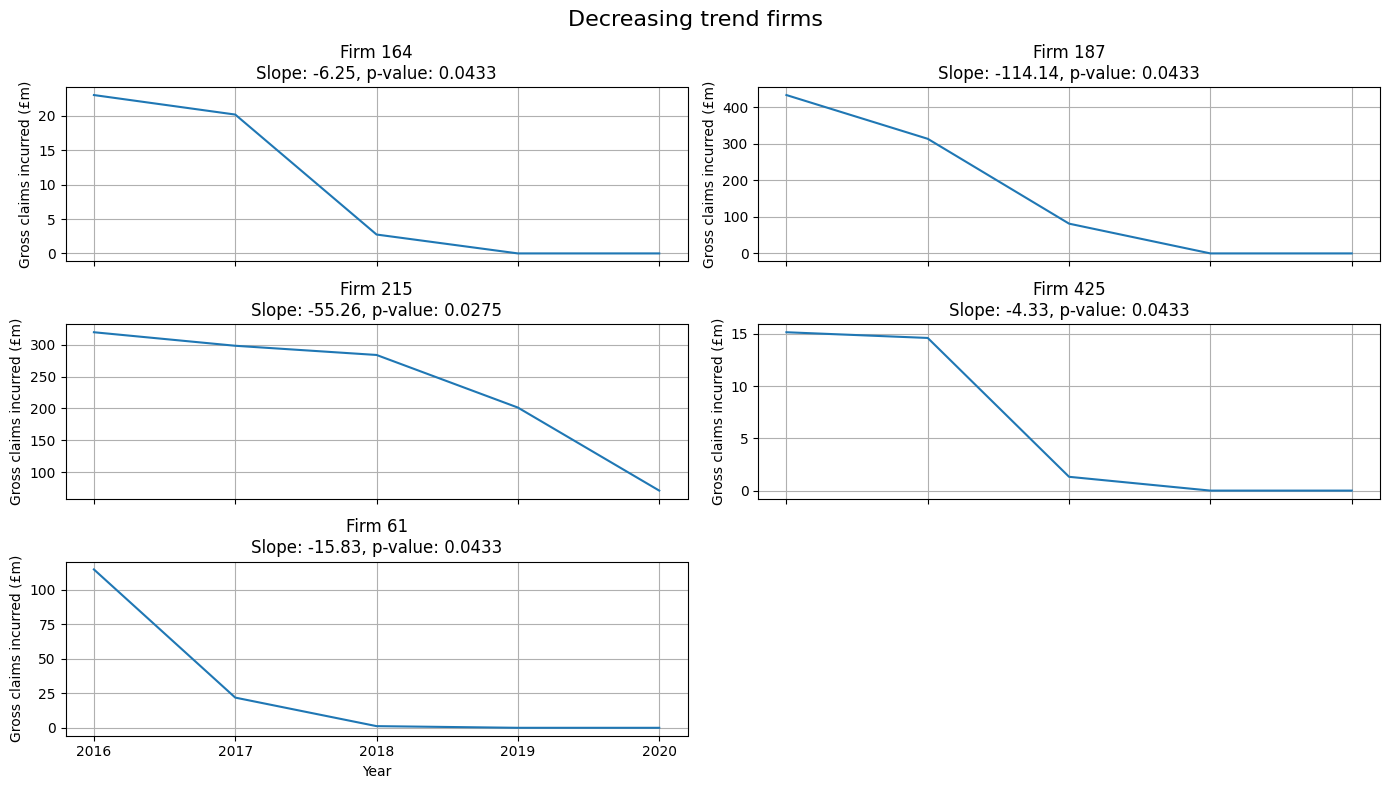

In [21]:
trending_firms = df_gci.merge(mk_results[mk_results.trend!='no trend'])
t = 'decreasing'
plot_time_series_with_slope(trending_firms, n_firms_per_row=2, figsize=(14, 8), trend_type = t)

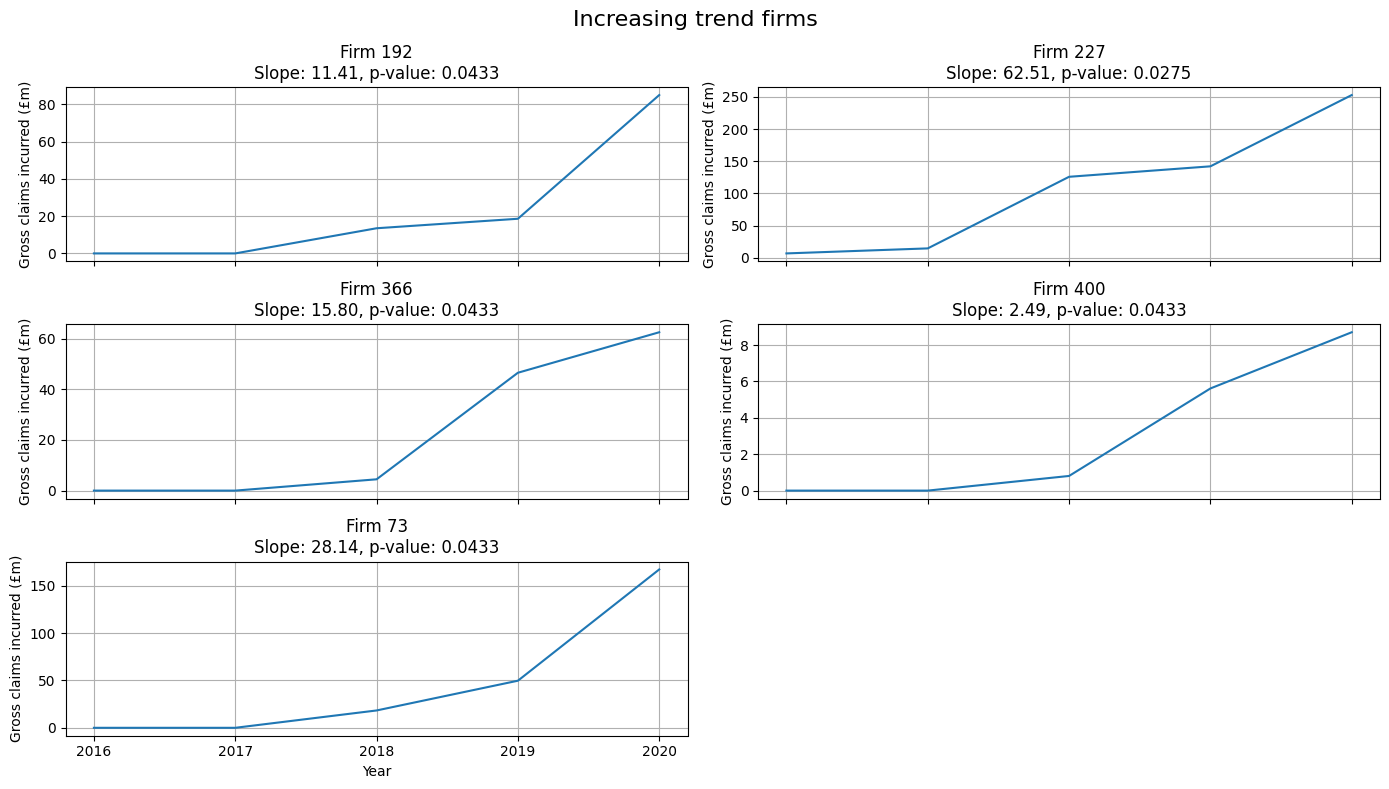

In [22]:
t = 'increasing'
plot_time_series_with_slope(trending_firms, n_firms_per_row=2, figsize=(14, 8), trend_type = t)

##### Method 5
SCR coverage ratio – a measure of whether a firm is meeting its prudential capital requirements. Greater than 100% means the firm is holding enough capital to meet the requirement. The size of the buffer (i.e. surplus over 100%) can be important.

In [23]:
scr_ratio_columns = [col for col in df_general.columns if col.startswith('SCR coverage ratio')]
df_scr_ratio = melt_columns(df=df_general, coloum_list=scr_ratio_columns, new_column_name='SCR_ratio', is_yoy=False)
top_scr_ratio = df_scr_ratio[df_scr_ratio.SCR_ratio>1].sort_values(by='SCR_ratio')
top_scr_ratio

,firm,Year,SCR_ratio
328,Firm 158,2019,1.010000e+00
638,Firm 213,2019,1.010000e+00
789,Firm 240,2020,1.010000e+00
605,Firm 208,2016,1.010000e+00
960,Firm 272,2016,1.020000e+00
...,...,...,...
1230,Firm 320,2016,6.735558e+06
1442,Firm 66,2018,7.161992e+06
1,Firm 1,2017,5.588700e+07
181,Firm 131,2017,9.269834e+08


In [24]:
def plot_requirement_graph(df):
    # Sort the DataFrame by 'is_risk_count' in descending order
    df_sorted = df.groupby(['firm']).size().sort_values(ascending=False).reset_index(name='year_count')
    df_sorted = df_sorted[df_sorted.year_count>3]
    all_years = df_sorted[df_sorted.year_count==5].shape[0]

    # Create a bar chart
    fig = go.Figure(data=[go.Bar(
        x=df_sorted['firm'],
        y=df_sorted['year_count'],
        marker_color=['green' if i <= all_years else 'blue' for i in range(len(df_sorted))],  # Highlight top 5 bars
        # text=df_sorted['is_risk_count'],  # Add text labels
        textposition='outside',  # Place text labels outside the bars
    )])

     # Update layout
    fig.update_layout(
        title='Number of Years Firm holding enough capital to meet the requirement',
        xaxis=dict(title='Firms'),
        yaxis=dict(title='Number of Years'),
        bargap=0.1,  # Gap between bars
        autosize=False,
        width=800,
        height=600
    )

    # Show the plot
    fig.show()

In [25]:
plot_requirement_graph(top_scr_ratio)

##### Method 6

Net combined ratio – (incurred losses plus expenses) / earned premiums. This is a ratio that

can indicate the profitability of a firm. If this is less than 100% it indicates a profit.

In [26]:
ncr_ratio_columns = [col for col in df_underwriting.columns if col.startswith('Net combined ratio')]
df_ncr_ratio = melt_columns(df=df_underwriting, coloum_list=ncr_ratio_columns, new_column_name='NCR_ratio', is_yoy=False)
top_ncr_ratio = df_ncr_ratio[df_ncr_ratio.NCR_ratio<1]


In [27]:
def plot_ncr_graph(df):
    # Sort the DataFrame by 'is_risk_count' in descending order
    df_sorted = df.groupby('firm').size().sort_values(ascending=False).reset_index(name='year_count')
    df_sorted = df_sorted[df_sorted.year_count>3]
    all_years = df_sorted[df_sorted.year_count==5].shape[0]

    # Create a bar chart
    fig = go.Figure(data=[go.Bar(
        x=df_sorted['firm'],
        y=df_sorted['year_count'],
        marker_color=['green' if i <= all_years else 'blue' for i in range(len(df_sorted))],  # Highlight top 5 bars
        # text=df_sorted['is_risk_count'],  # Add text labels
        textposition='outside',  # Place text labels outside the bars
    )])

     # Update layout
    fig.update_layout(
        title='Number of Years Firm are having profit',
        xaxis=dict(title='Firms'),
        yaxis=dict(title='Number of Years'),
        bargap=0.1,  # Gap between bars
        autosize=False,
        width=800,
        height=600
    )

    # Show the plot
    fig.show()

In [28]:
plot_ncr_graph(top_ncr_ratio)

#### Method 7

Firms with high liabilities in £m 

In [29]:
equity_columns = [col for col in df_general.columns if col.startswith('Excess of assets over liabilities (£m) [= equity]')]
df_general['Equity'] = df_general[equity_columns].sum(axis=1)
neg_equity = df_general[df_general.Equity<0]

fig = px.bar(neg_equity, y='firm', x='Equity', title='Firms with Negative assets over liabilities (£m)')
fig.update_layout(xaxis_title='Liabilities (£m)', yaxis_title='Firm')

### Task 2

##### Machine Learning Model

We build a model to predict if the a firm hold enough capital to meet requirements. It is classification problem with 1 means it is holds enough capital and 0 mean otherwise. It is important to know which firm does have surplus over 100%.

In [30]:
df_base = pd.DataFrame(df['firm'])
for col_list in feature_columns:
    new_column_name = col_list[0][:-7]
    re = melt_columns(df, coloum_list=col_list, new_column_name=new_column_name, is_yoy=False)
    df_base = df_base.merge(re, how='left')
df_base


,firm,Year,NWP (£m),SCR (£m),EoF for SCR (£m),SCR coverage ratio,GWP (£m),Total assets (£m),Total liabilities (£m),Excess of assets over liabilities (£m) [= equity],Gross claims incurred (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)","Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Pure net claims ratio,Net expense ratio,Net combined ratio,Pure gross claims ratio,Gross expense ratio,Gross combined ratio
0,Firm 1,2016,-17754.100486,2.021322e+03,2416.559785,1.625197e-01,46.768030,63676.869102,40171.683156,1243.924991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Firm 1,2017,0.000000,6.940043e-09,3.796177,5.588700e+07,0.000000,9.566096,0.000000,4.398725,0.005515,0.588994,9.894597,17.184308,41.013060,71.298841,17.534691,77.251254,0.675051
2,Firm 1,2018,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Firm 1,2019,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Firm 1,2020,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,Firm 99,2016,281.402333,1.218816e+02,546.542795,2.142808e+00,178.699850,652.079271,351.404429,64.292877,116.533448,296.108757,486.959142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2276,Firm 99,2017,120.760121,1.508998e+02,49.700708,1.211951e+00,557.712342,1244.259065,616.968029,480.426485,12.181508,517.346887,45.496220,-33721.020240,-7038.624063,-73450.271014,-24817.785823,-16112.406623,-2354.862219
2277,Firm 99,2018,308.352528,2.206094e+02,624.276669,7.536688e-01,421.335272,1825.252764,239.030849,634.150357,3.278956,124.930948,27.495378,0.000000,0.000000,0.000000,75.963943,0.216016,243.283352
2278,Firm 99,2019,112.029932,4.138812e+02,422.598443,2.059566e-01,932.918985,1007.841681,1119.735100,37.813704,-2.412095,392.937568,9.857067,0.000000,0.000000,0.000000,0.833271,-5.835922,-1.233277


In [31]:
df_base.describe()

,NWP (£m),SCR (£m),EoF for SCR (£m),SCR coverage ratio,GWP (£m),Total assets (£m),Total liabilities (£m),Excess of assets over liabilities (£m) [= equity],Gross claims incurred (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)","Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Pure net claims ratio,Net expense ratio,Net combined ratio,Pure gross claims ratio,Gross expense ratio,Gross combined ratio
count,1625.000000,1625.000000,1625.000000,1.625000e+03,1625.000000,1625.000000,1625.000000,1625.000000,2280.000000,2280.000000,2280.000000,2280.000000,2.280000e+03,2.280000e+03,2280.000000,2280.000000,2.280000e+03
mean,731.756135,346.635184,504.096123,1.228704e+06,936.694961,7244.856179,7080.304690,539.107196,128.384523,285.115521,181.363743,349.188087,-7.911175e+02,-2.403903e+03,422.752181,247.213953,1.744681e+03
std,3969.009525,1570.005997,2262.296981,3.383049e+07,4757.190907,33462.818642,33527.811705,2174.167392,431.408877,1007.437106,637.592586,17372.269636,1.097487e+05,1.145433e+05,20635.934856,12050.858858,8.331728e+04
min,-17754.100486,0.000000,-162.245016,-3.488211e+00,-19.777480,-207.356238,-1487.107764,-123.609578,-189.936333,-167.815824,-182.381851,-33721.020240,-4.495420e+06,-5.468706e+06,-24817.785823,-16112.406623,-1.406448e+04
25%,0.000000,0.738866,2.879599,2.914672e-01,0.000000,6.543713,0.847367,3.515754,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
50%,3.625627,11.637984,25.548589,1.587490e+00,8.686859,85.932872,45.545844,29.582864,0.687716,4.514229,1.319210,0.000000,2.420209e-02,5.092779e-02,0.025116,0.039206,9.849834e-02
75%,90.225184,91.415724,162.428978,3.061232e+00,178.699850,926.199445,643.826070,166.413248,65.630329,146.634626,80.476426,0.532303,4.022814e-01,9.978883e-01,0.602362,0.347480,9.810006e-01
max,75526.673293,22788.359468,41636.299252,9.993029e+08,74078.635849,553549.903858,494498.525611,26705.042053,6844.014131,19292.066525,11351.609021,828809.371523,2.691212e+06,4.318219e+04,985011.303759,575064.786983,3.978266e+06


In [32]:
df_base = df_base.dropna(subset=['SCR coverage ratio'])
target = 'is_important'
df_base[target] = np.where(df_base['SCR coverage ratio'] > 1, 1, 0)
df_base = df_base.drop(columns=['SCR coverage ratio', 'firm', 'Year']) 
X = df_base.drop(columns=target)
y = df_base[target]
X

,NWP (£m),SCR (£m),EoF for SCR (£m),GWP (£m),Total assets (£m),Total liabilities (£m),Excess of assets over liabilities (£m) [= equity],Gross claims incurred (£m),"Gross BEL (inc. TPs as whole, pre-TMTP) (£m)","Net BEL (inc. TPs as a whole, pre-TMTP) (£m)",Pure net claims ratio,Net expense ratio,Net combined ratio,Pure gross claims ratio,Gross expense ratio,Gross combined ratio
0,-17754.100486,2.021322e+03,2416.559785,46.768030,63676.869102,40171.683156,1243.924991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,6.940043e-09,3.796177,0.000000,9.566096,0.000000,4.398725,0.005515,0.588994,9.894597,17.184308,41.013060,71.298841,17.534691,77.251254,0.675051
2,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,281.402333,1.218816e+02,546.542795,178.699850,652.079271,351.404429,64.292877,116.533448,296.108757,486.959142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2276,120.760121,1.508998e+02,49.700708,557.712342,1244.259065,616.968029,480.426485,12.181508,517.346887,45.496220,-33721.020240,-7038.624063,-73450.271014,-24817.785823,-16112.406623,-2354.862219
2277,308.352528,2.206094e+02,624.276669,421.335272,1825.252764,239.030849,634.150357,3.278956,124.930948,27.495378,0.000000,0.000000,0.000000,75.963943,0.216016,243.283352
2278,112.029932,4.138812e+02,422.598443,932.918985,1007.841681,1119.735100,37.813704,-2.412095,392.937568,9.857067,0.000000,0.000000,0.000000,0.833271,-5.835922,-1.233277


#### Helper Functions

In [33]:
def visualize_count_pie(df, column):
    """
    Visualize the count and percentage of records for each category in the specified column using a pie chart.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column (str): The column name to visualize.
    """
    # Calculate count and percentage for each category
    count_series = df[column].value_counts()
    total_records = count_series.sum()
    percentage_series = count_series / total_records * 100

    # Create labels for the pie chart
    labels = [f'{label} ({percentage:.2f}%)' for label, percentage in zip(count_series.index, percentage_series)]

    # Create Pie chart trace
    trace = go.Pie(labels=labels, values=count_series.values, hole=0.3)

    # Create layout
    layout = go.Layout(title=f'Count and Percentage of Records for {column.capitalize()}')

    # Create figure
    fig = go.Figure(data=[trace], layout=layout)

    # Show plot
    fig.show()

def visualize_null_values(df):
    # Step 1: Count the number of nulls in each column
    null_counts = df.isnull().sum()

    # Step 2: Calculate the percentage of total records for each column
    total_records = len(df)
    null_percent = (null_counts / total_records) * 100

    # Step 3: Create a summary DataFrame
    null_summary = pd.DataFrame({
        'Null Count': null_counts,
        'Null Percent': null_percent
    })

    # Sort the DataFrame by the percentage of nulls
    null_summary_sorted = null_summary.sort_values(by='Null Percent', ascending=False)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    null_summary_sorted['Null Percent'].plot(kind='bar', color='skyblue')
    plt.title('Percentage of Null Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('Null Percent')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    plt.show()


def apply_smote(x, y):
    # Assuming X and y are your feature matrix and target vector
    smote = SMOTE(sampling_strategy='auto', random_state=18)
    X_resampled, y_resampled = smote.fit_resample(x, y)

    return X_resampled, y_resampled

def plot_class_counts_before_after_smote(y_train, y_train_resampled):
    # Calculate class counts before SMOTE
    class_counts_before = dict(Counter(y_train))

    class_counts_after = dict(Counter(y_train_resampled))

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Before SMOTE
    sns.barplot(x=list(class_counts_before.keys()), y=list(class_counts_before.values()), ax=axs[0])
    axs[0].set_title('Class Counts Before SMOTE')
    axs[0].set_xlabel('Class')
    axs[0].set_ylabel('Count')

    # After SMOTE
    sns.barplot(x=list(class_counts_after.keys()), y=list(class_counts_after.values()), ax=axs[1])
    axs[1].set_title('Class Counts After SMOTE')
    axs[1].set_xlabel('Class')
    axs[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, top_n=10):
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]
    # top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_importances)), top_importances, align='center')
    # plt.yticks(range(len(top_importances)), top_features)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top {} Feature Importances'.format(top_n))
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

def plot_roc_curve_and_confusion_matrix(model, X_test, y_test):
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predict class labels
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 3))

    # Plot ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout() # Adjust layout to prevent overlap

    plt.show()

def plot_skewness(skew_df):
    fig, ax = plt.subplots(figsize=(25, 7))

    ax.bar(x=skew_df[(skew_df < 2) & (skew_df > -2)].index, height=skew_df[(skew_df < 2) & (skew_df > -2)], color="g", label="Semi-normal distribition")
    ax.bar(x=skew_df[skew_df > 2].index, height=skew_df[skew_df > 2], color="r", label="Positively skewed features")
    ax.bar(x=skew_df[skew_df < -2].index, height=skew_df[skew_df < -2], color="b", label="Negatively skewed features")
    ax.legend()
    fig.suptitle("Skewness of numerical columns", fontsize=20)
    ax.tick_params(labelrotation=90)
    plt.show()

def plot_kurtosis(kurtosis_df):
    fig, ax = plt.subplots(figsize=(25, 7))

    ax.bar(x=kurtosis_df[(kurtosis_df < 7) & (kurtosis_df > -7)].index, height=kurtosis_df[(kurtosis_df < 7) & (kurtosis_df > -7)], color="g", label="Semi-normal distribition")
    ax.bar(x=kurtosis_df[kurtosis_df > 7].index, height=kurtosis_df[kurtosis_df > 7], color="r", label="Positive kurtosis")
    ax.bar(x=kurtosis_df[kurtosis_df < -7].index, height=kurtosis_df[kurtosis_df < -7], color="b",  label="Negative kurtosis")
    ax.legend()
    fig.suptitle("Kurtosis of numerical columns", fontsize=20)
    ax.tick_params(labelrotation=90)
    plt.show()

def visualize_distribution_transformations(df, non_dist_cols):
    fig, ax = plt.subplots(len(non_dist_cols), 4, figsize=(30, 40))
    for i, col in tqdm(enumerate(non_dist_cols)):
        # Scale
        scaler = QuantileTransformer(output_distribution="normal")
        quant_df = scaler.fit_transform(df[[col]])

        ax[i, 0].hist(df[col], color="r")
        ax[i, 1].hist(quant_df, color="b")
        ax[i, 2].hist(np.log1p(df[col]), color="orange")
        
        ax[i, 0].set_title(f"Original Distribution({col})")
        ax[i, 1].set_title(f"Quantile Scaling ({col})")
        ax[i, 2].set_title(f"Log transform ({col})")
        ax[i, 3].set_title(f"Square Root ({col})")
        ax[i, 3].hist(np.sqrt(df[col]), color="green")
    
    plt.tight_layout(pad=4)
    plt.show()

def plot_correlation_heatmap(df, target):
    plt.figure(figsize=(25, 12))
    
    # Concatenate train and test data to compute correlation
    corr = df.corr()
    
    # Create a mask for the upper triangle
    upper_triangle = np.triu(np.ones_like(corr, dtype=bool))
    
    # Plot the heatmap
    sns.heatmap(corr, vmin=-1, vmax=1, cmap="Spectral", annot=True, mask=upper_triangle)
    plt.title("Correlation of all features and target", fontsize=18)
    plt.show()

def plot_box_plots(df, numerical):
    fig, ax = plt.subplots(int(np.ceil(len(numerical)/4)), 4, figsize=(30, 20))
    ax = np.ravel(ax)

    for i, col in enumerate(numerical):
        sns.boxplot(ax=ax[i], x=df[col], color="blue")

    fig.suptitle("Box plots of all data", fontsize=40)
    plt.tight_layout(pad=3)
    plt.show()

def scale_quantile_transform(train_data, test_data):
    
    scaler = QuantileTransformer(output_distribution="normal")
    
    scaled_train_data = scaler.fit_transform(train_data)
    
    scaled_test_data = scaler.transform(test_data)
    
    return scaled_train_data, scaled_test_data

def pca_and_drop(df_train, df_test, n_components):
    # Perform PCA
    pca = PCA(n_components=n_components)
    df_train = pca.fit_transform(df_train)
    df_test = pca.transform(df_test)

    return pca, df_train, df_test


#### EDA and Feature  Engineering

In [34]:
visualize_count_pie(df_base, 'is_important')

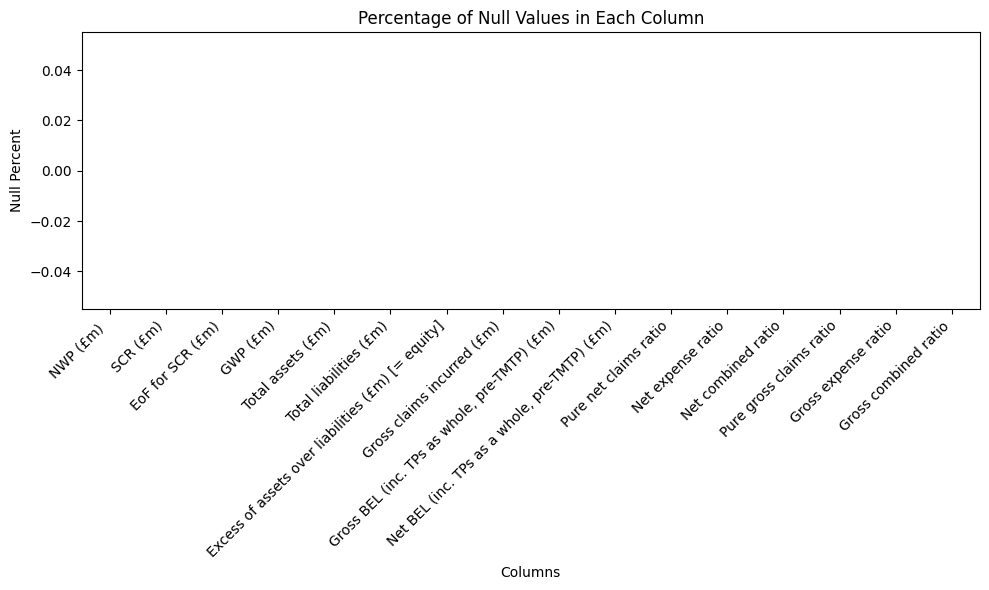

In [35]:
visualize_null_values(X)

In [36]:
skew_df = X.skew(numeric_only=True).sort_values()
print("Skewly distributed columns by skewness value:\n") 
display(skew_df)

Skewly distributed columns by skewness value:



Net combined ratio                                  -20.478975
Gross claims incurred (£m)                            6.917307
Excess of assets over liabilities (£m) [= equity]     7.325069
Net BEL (inc. TPs as a whole, pre-TMTP) (£m)          7.730981
Total liabilities (£m)                                8.025595
Gross BEL (inc. TPs as whole, pre-TMTP) (£m)          8.309817
SCR (£m)                                              8.713040
Total assets (£m)                                     9.150586
GWP (£m)                                             10.429337
EoF for SCR (£m)                                     10.622716
NWP (£m)                                             10.638307
Pure net claims ratio                                40.208499
Gross expense ratio                                  40.253863
Pure gross claims ratio                              40.270082
Gross combined ratio                                 40.310209
Net expense ratio                                    40

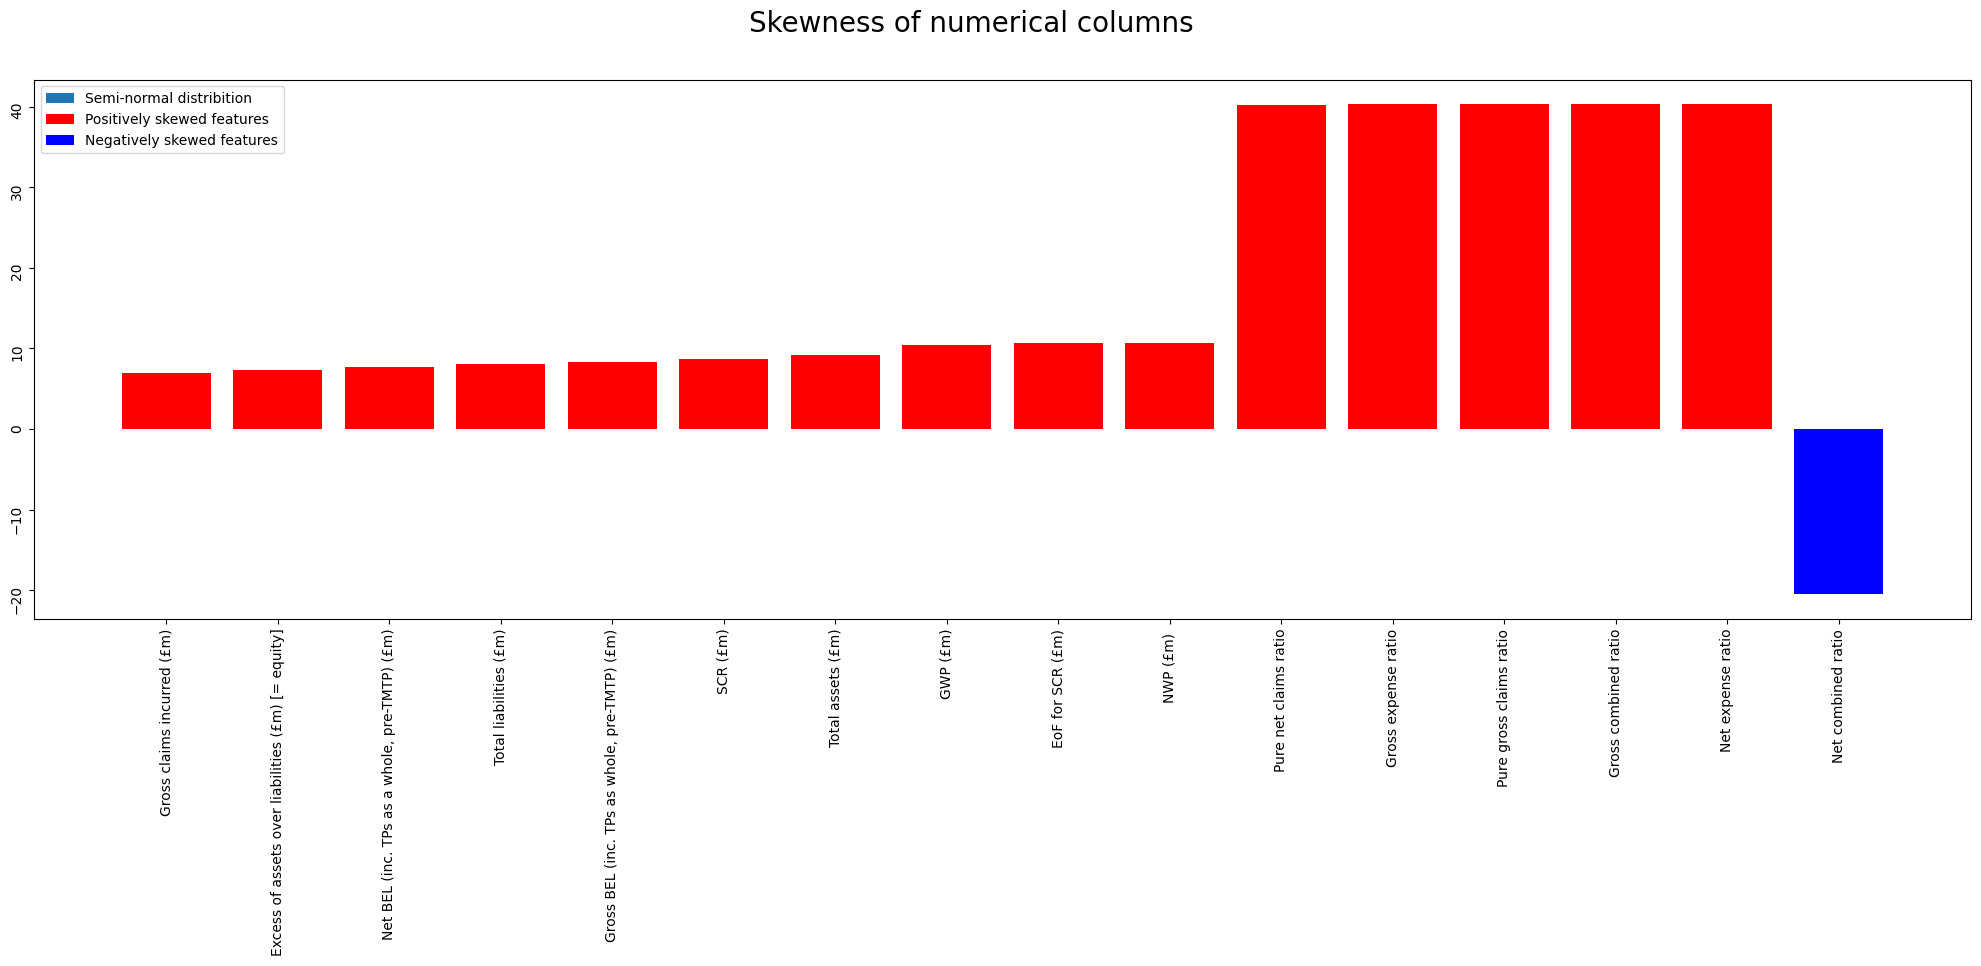

In [37]:
plot_skewness(skew_df)

In [38]:
kurtosis_df = X.kurtosis().sort_values()
print("Tailed columns by kurtosis value\n") 
display(kurtosis_df)

Tailed columns by kurtosis value



Gross claims incurred (£m)                             62.732881
Excess of assets over liabilities (£m) [= equity]      65.426245
Net BEL (inc. TPs as a whole, pre-TMTP) (£m)           79.050073
Total liabilities (£m)                                 81.501363
SCR (£m)                                               90.085484
Gross BEL (inc. TPs as whole, pre-TMTP) (£m)           95.849233
Total assets (£m)                                     112.722639
GWP (£m)                                              132.416180
EoF for SCR (£m)                                      147.559386
NWP (£m)                                              148.497156
Net combined ratio                                    997.931404
Pure net claims ratio                                1619.624413
Gross expense ratio                                  1621.957932
Pure gross claims ratio                              1622.819690
Gross combined ratio                                 1624.941769
Net expense ratio        

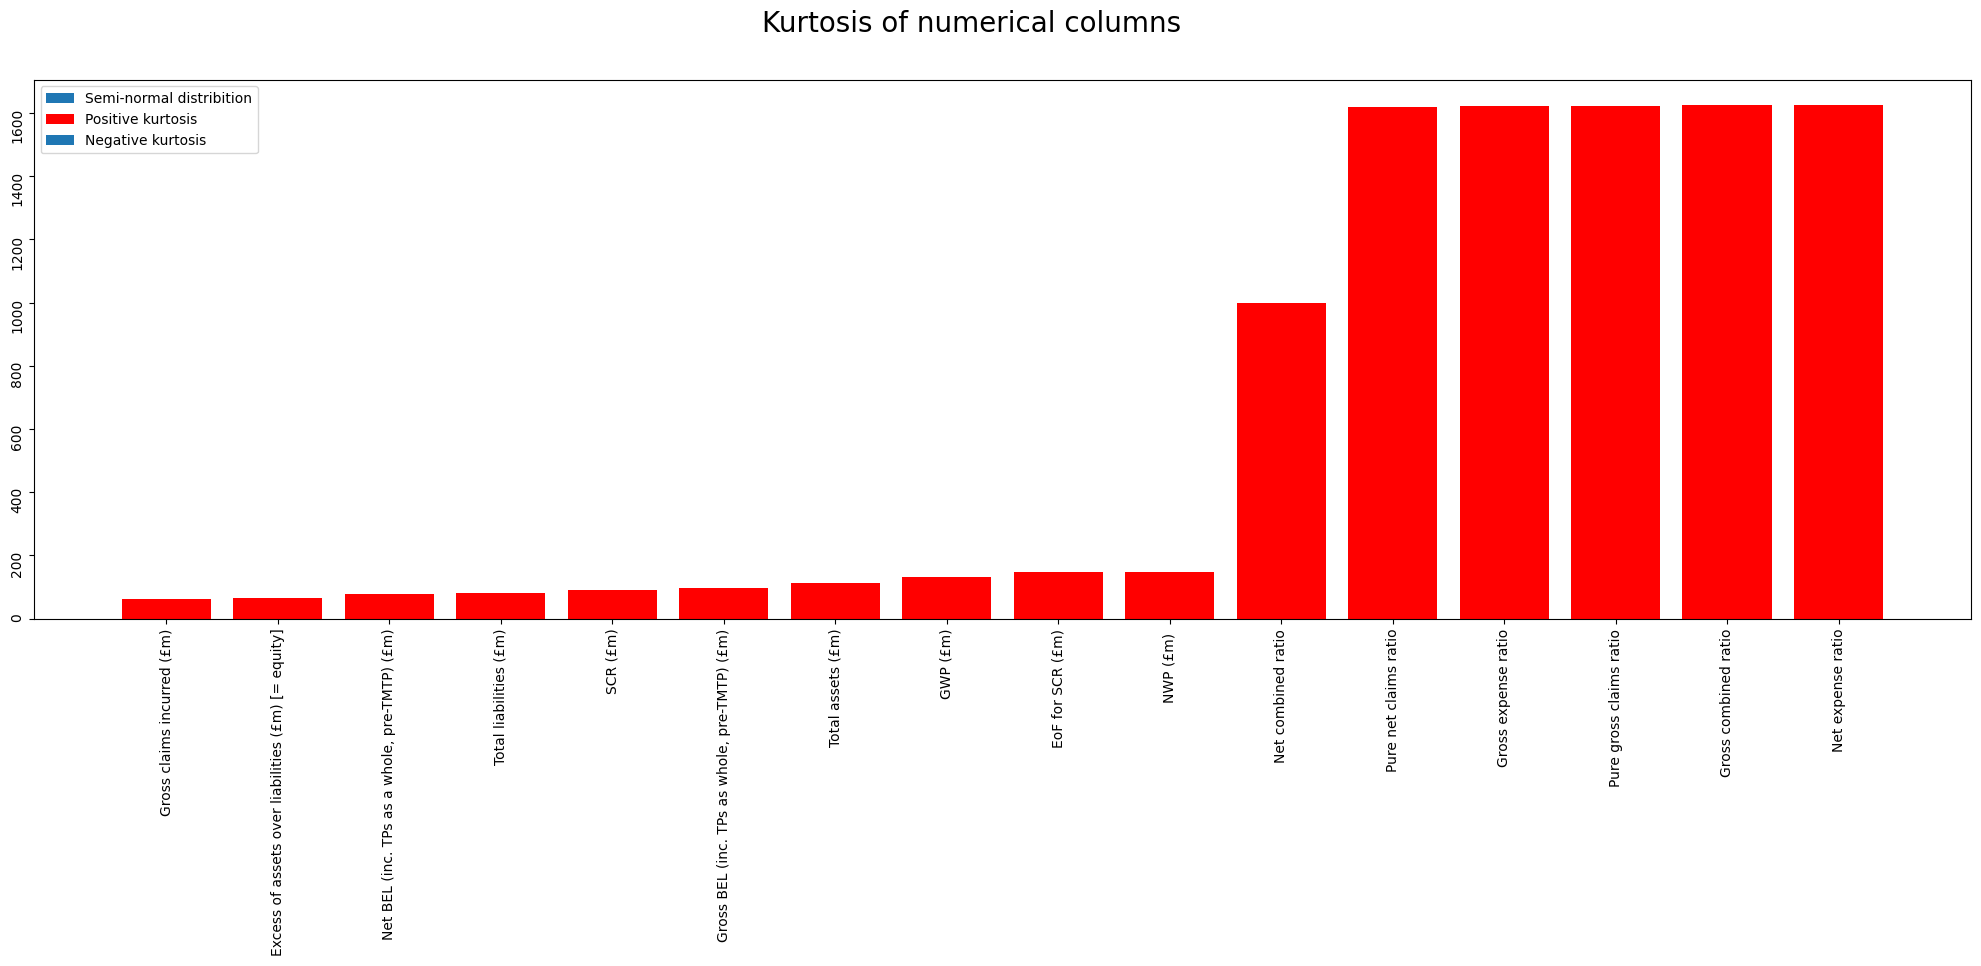

In [39]:

plot_kurtosis(kurtosis_df)

16it [00:00, 36.15it/s]


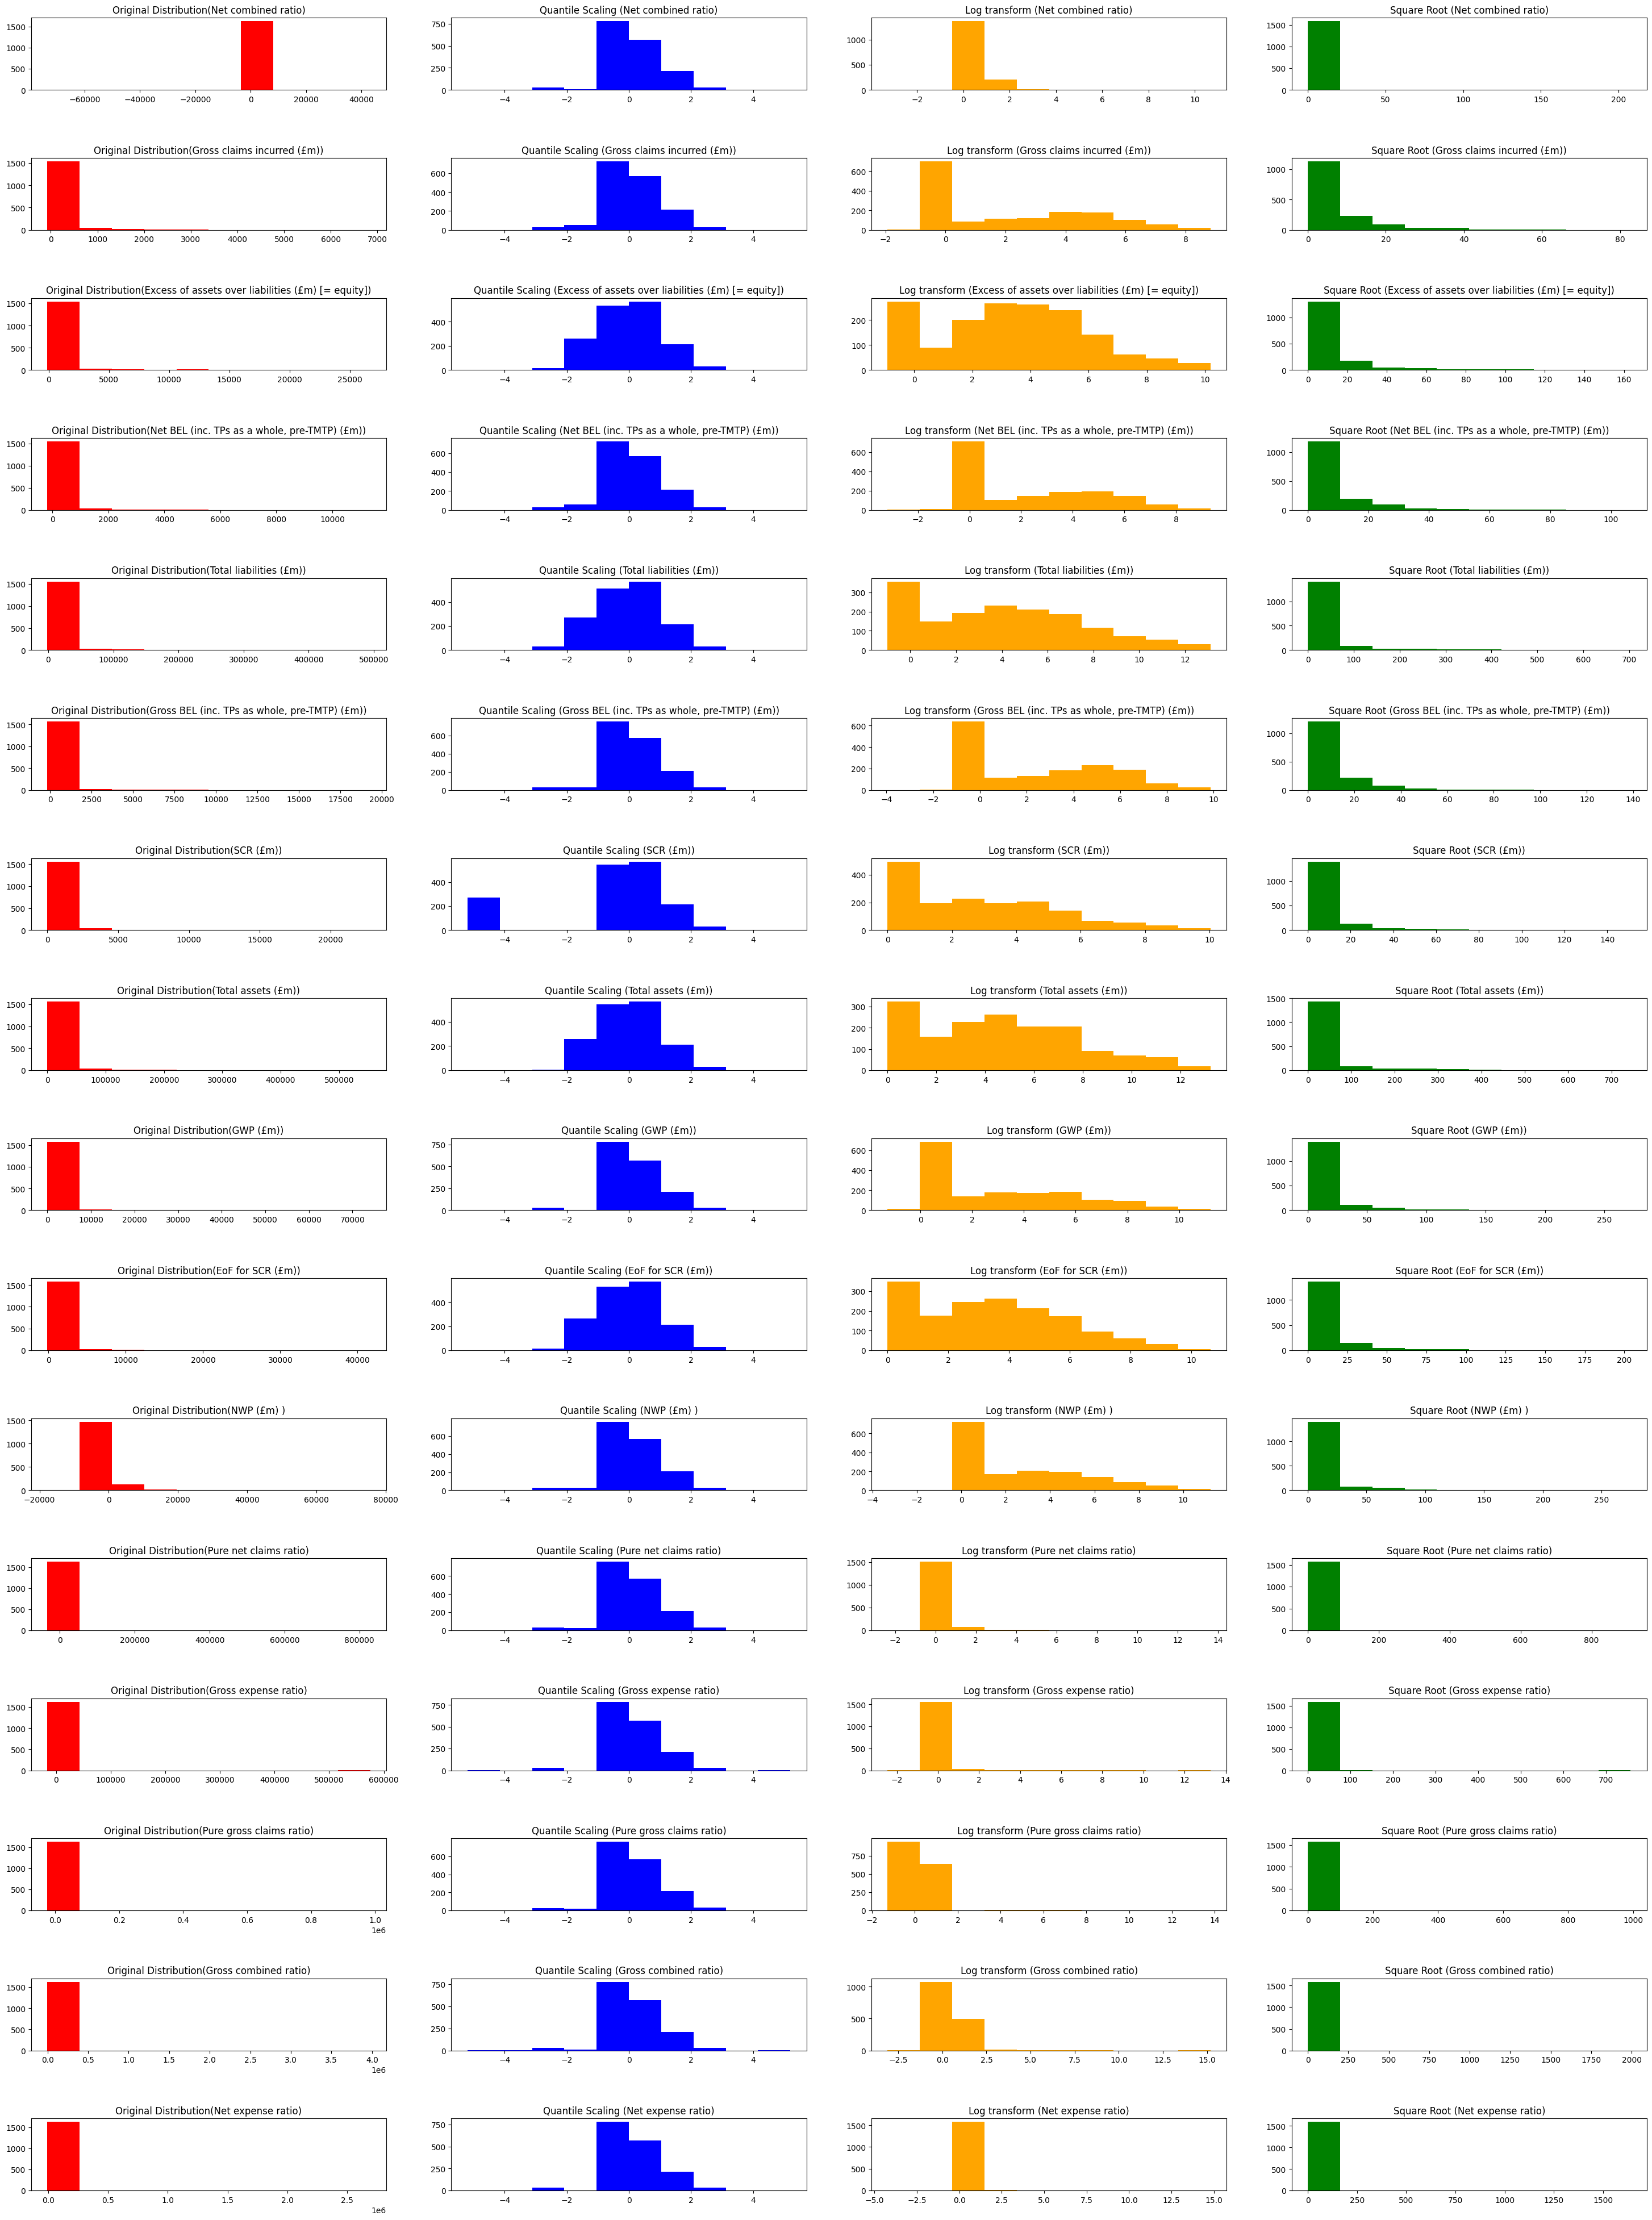

In [40]:
visualize_distribution_transformations(X, skew_df.index.to_list())

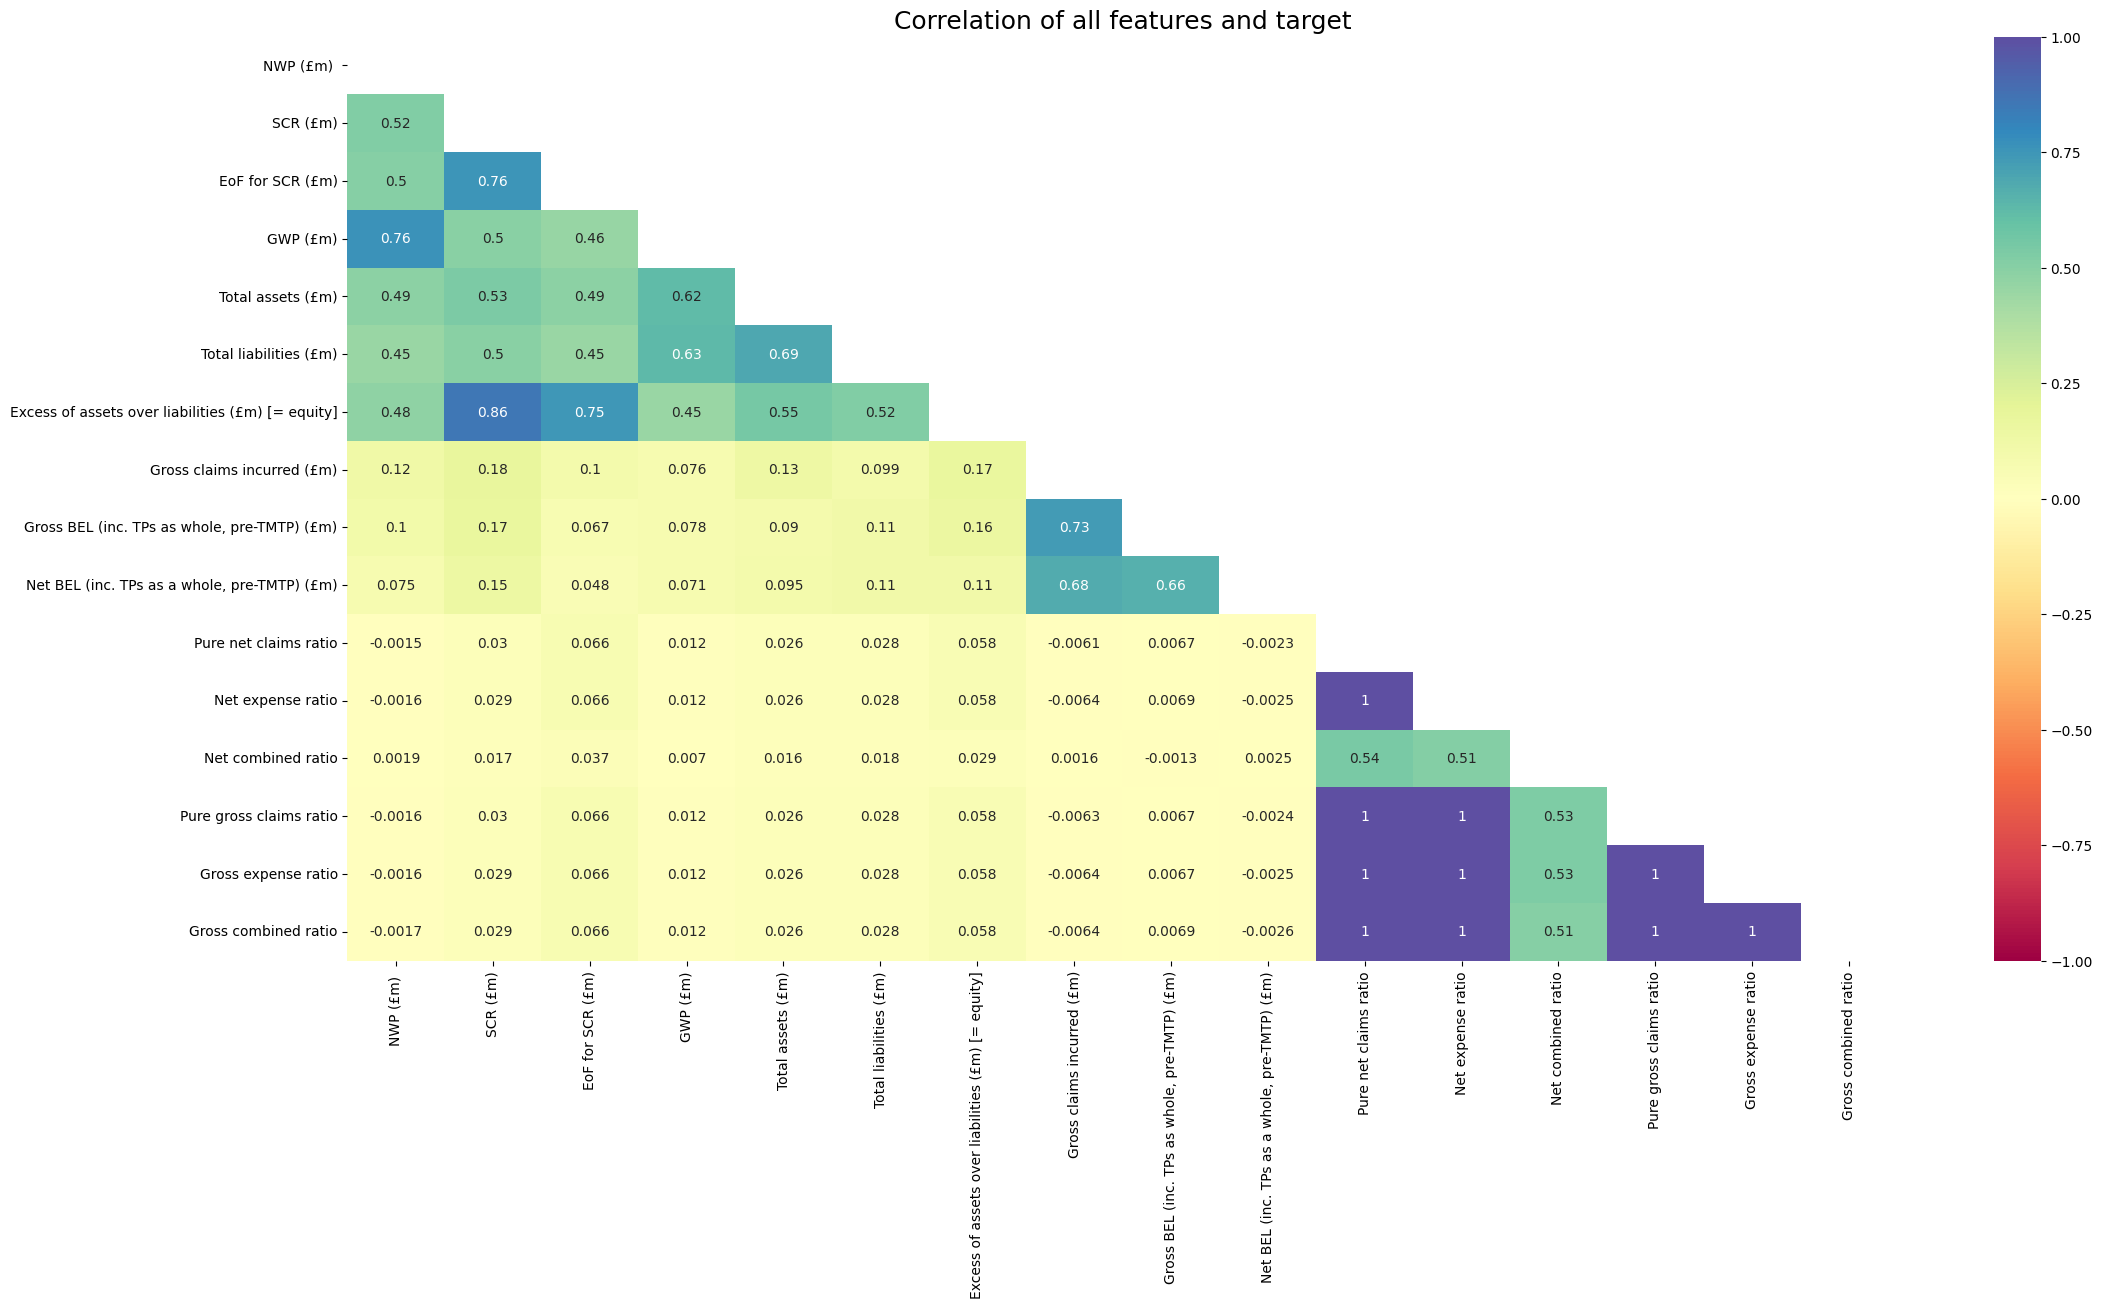

In [41]:
plot_correlation_heatmap(X, 'target_column_name')

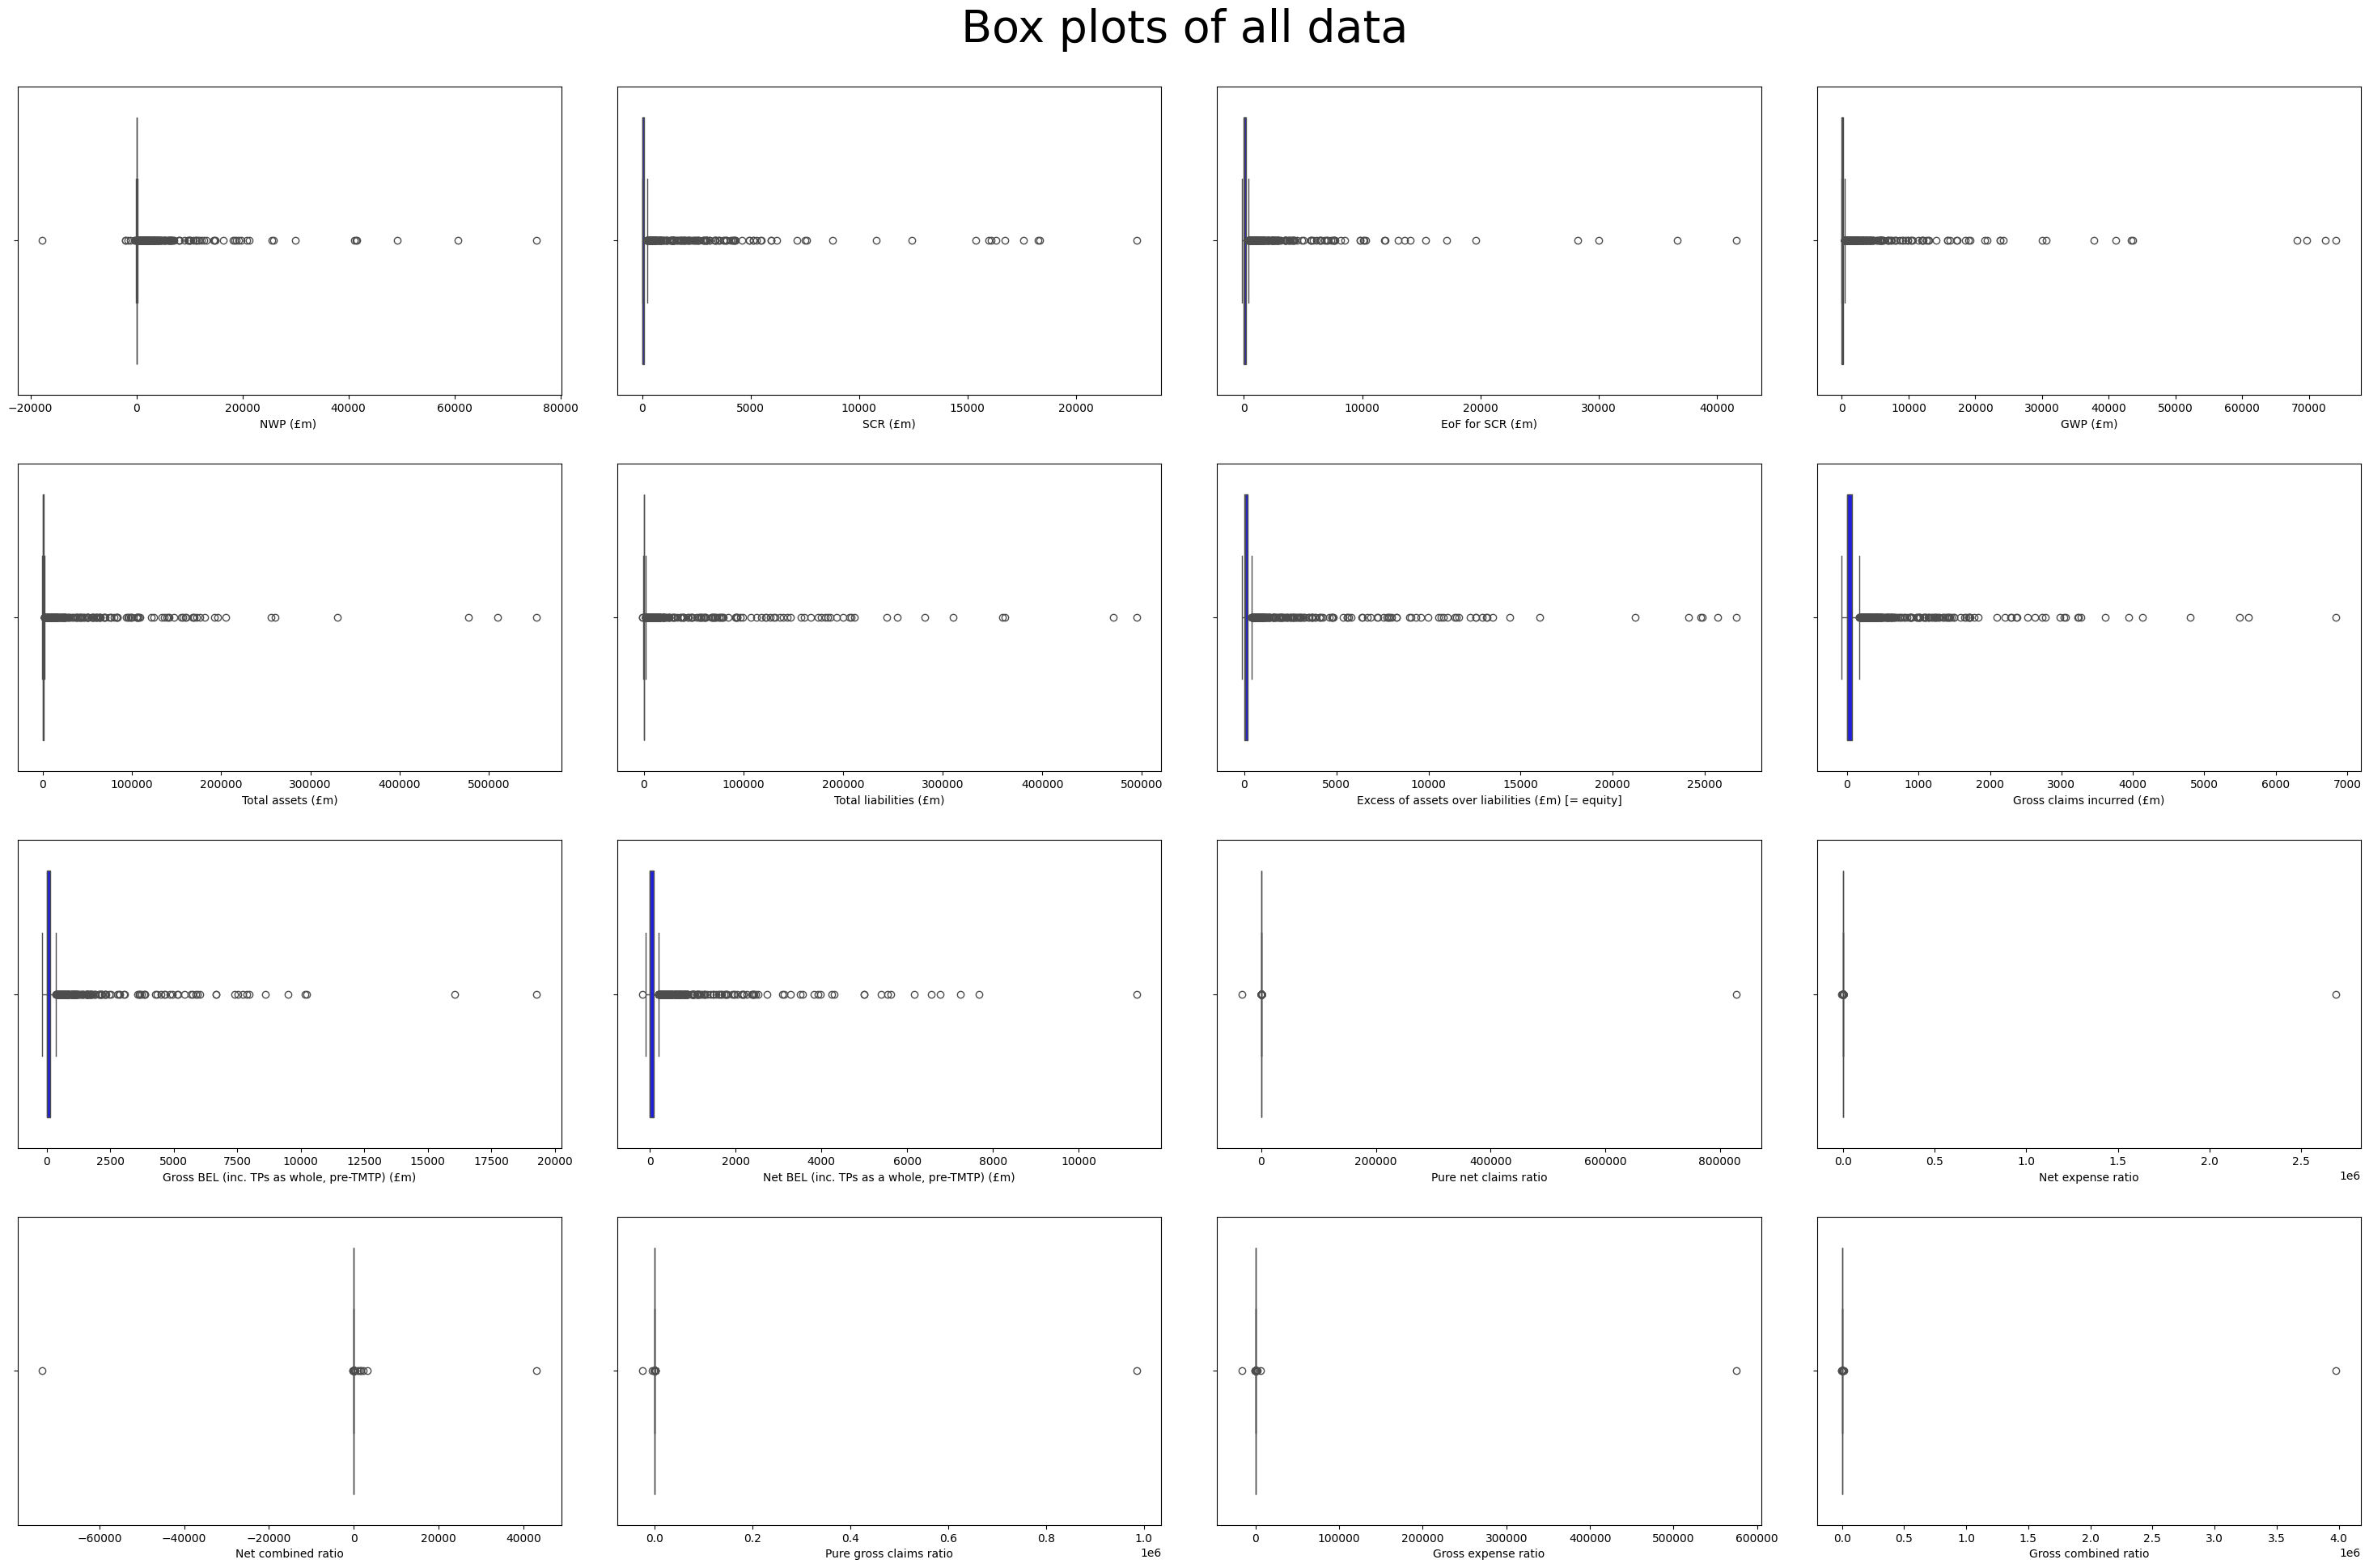

In [42]:
# Box plot to see the outliers in each column
plot_box_plots(X, X.columns.to_list())

In [43]:
# Train test data before applying any transformations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(1300, 16) (325, 16) (1300,) (325,)


In [44]:
X_train_scaled, X_test_scaled = scale_quantile_transform(X_train, X_test)

In [45]:
pca, X_train_pca, X_test_pca = pca_and_drop(X_train_scaled, X_test_scaled, n_components=0.95)
# pca, X_train_pca, X_test_pca = pca_and_drop(X_train, X_test, n_components=0.95)
print(f'Number of Features {len(X_train_pca[0])}')

Number of Features 10


In [46]:
X_train_smote, y_train_smote = apply_smote(X_train_pca, y_train)

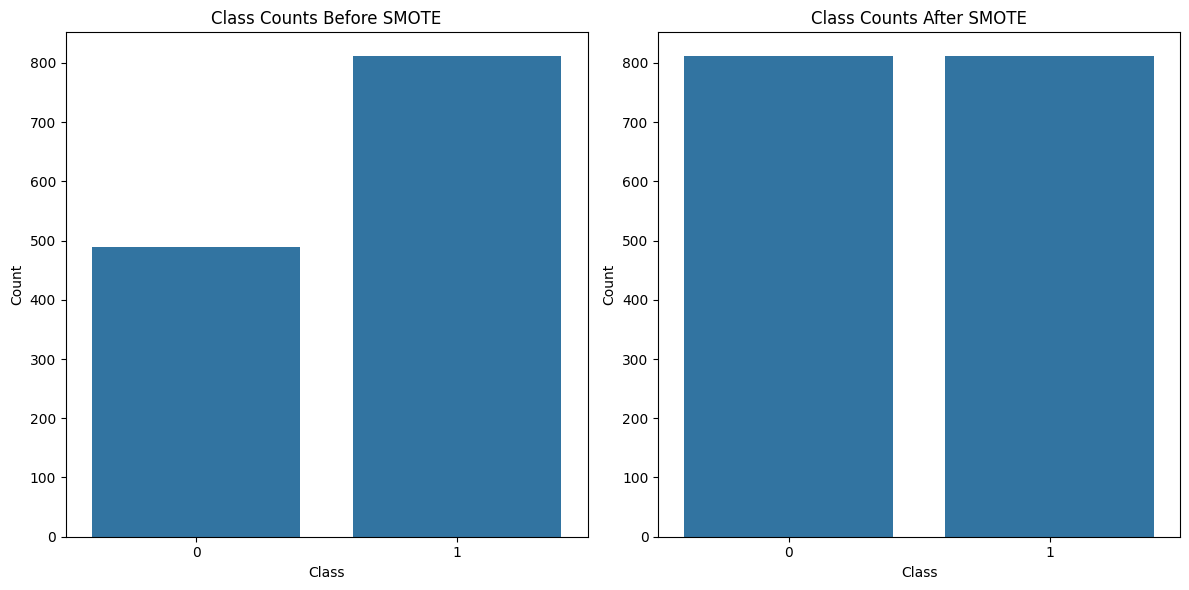

In [47]:
plot_class_counts_before_after_smote(y_train, y_train_smote)

#### Build Model

              precision    recall  f1-score   support

           0       0.78      0.51      0.62       137
           1       0.71      0.89      0.79       188

    accuracy                           0.73       325
   macro avg       0.75      0.70      0.71       325
weighted avg       0.74      0.73      0.72       325



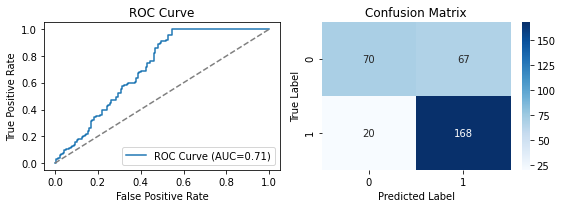

In [57]:
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_train_smote, y_train_smote)
plot_roc_curve_and_confusion_matrix(lr_model, X_test_pca, y_test)

              precision    recall  f1-score   support

           0       0.72      0.62      0.67       137
           1       0.75      0.82      0.78       188

    accuracy                           0.74       325
   macro avg       0.73      0.72      0.73       325
weighted avg       0.74      0.74      0.74       325



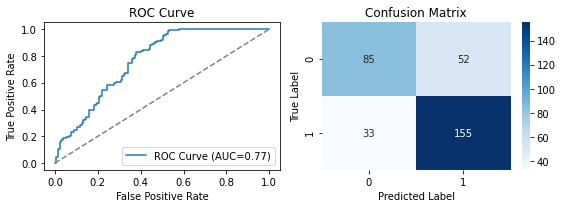

In [58]:
xg = xgb.XGBClassifier()
xgb_model = xg.fit(X_train_smote, y_train_smote)
plot_roc_curve_and_confusion_matrix(xgb_model, X_test_pca, y_test)

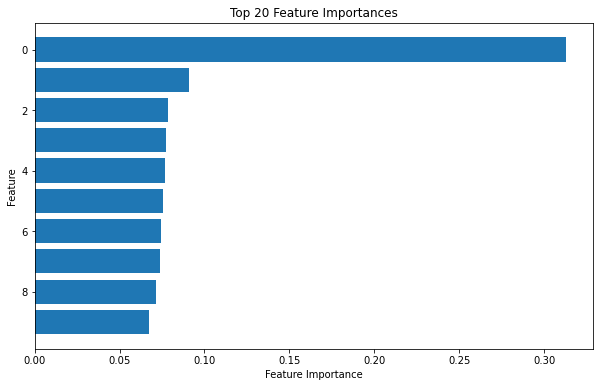

In [59]:
plot_feature_importance(xgb_model, top_n=20)

#### Hyperparameter Tuning

In [61]:
def objective(params):
    # Define XGBoost model with given hyperparameters
    model = xgb.XGBClassifier(**params)
    
    # Evaluate model using cross-validation
    cv_score = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy').mean()
    
    return {'loss': -cv_score, 'status': STATUS_OK}

# Define search space for hyperparameters
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000, 100)),
    'max_depth': hp.choice('max_depth', range(3, 11)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
}

# Run Hyperopt optimization
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("Best Hyperparameters:", best_params)

100%|██████████| 100/100 [04:53<00:00,  2.94s/trial, best loss: -0.7937215160663808]
Best Hyperparameters: {'colsample_bytree': 0.9648788894094354, 'learning_rate': 0.02882630101059812, 'max_depth': 7, 'n_estimators': 5, 'subsample': 0.8630919328429654}


              precision    recall  f1-score   support

           0       0.81      0.55      0.66       137
           1       0.74      0.90      0.81       188

    accuracy                           0.76       325
   macro avg       0.77      0.73      0.73       325
weighted avg       0.77      0.76      0.75       325



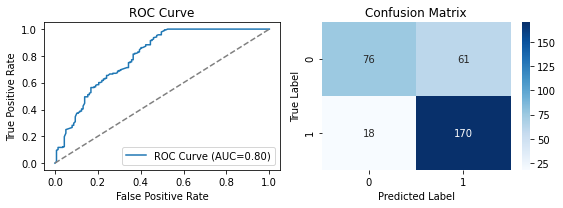

In [62]:
best_model = xgb.XGBClassifier(**best_params).fit(X_train_smote, y_train_smote)
plot_roc_curve_and_confusion_matrix(best_model, X_test_pca, y_test)

In [70]:
# {'colsample_bytree': 0.9648788894094354, 'learning_rate': 0.02882630101059812, 'max_depth': 7, 'n_estimators': 5, 'subsample': 0.8630919328429654}